<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Neuronal Network Based Strategy

How to predict Stocks Returns with Neuronal Networks

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))         # size fo the graph

In [4]:
symbol = ["MSFT"]
rawdata = yf.download(symbol, start="2010-01-01", end="2020-07-25", interval = "1d")

[*********************100%***********************]  1 of 1 completed


In [5]:
rawdata = pd.DataFrame(rawdata['Close'])
rawdata.columns = ['price']

In [6]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2010-01-04 to 2020-07-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2658 non-null   float64
dtypes: float64(1)
memory usage: 41.5 KB


In [7]:
data = rawdata[:-1].copy()
data['returns'] = np.log(data/data.shift(1))
data['direction'] = np.where(data['returns'] > 0 , 1,0)


# Calculates Simple Moving Averages with a long and a short window
data['SMA1'] = data['price'].rolling(20).mean().shift(1)
data['SMA2'] = data['price'].rolling(60).mean().shift(1)
data['dSMA'] = data['SMA1'] - data['SMA2']

# Calculates Equally Weighted Moving Average with a long and a short halflife
data['EWMA1'] = data['price'].ewm(halflife=20).mean().shift(1)
data['EWMA2'] = data['price'].ewm(halflife=60).mean().shift(1)
data['dEWMA'] = data['EWMA1'] - data['EWMA2']

# Calculates the moving standard deviation
data['vol1'] = data['price'].rolling(20).std().shift(1)
data['vol2'] = data['price'].rolling(60).std().shift(1)

# Deletes NA rows
data.dropna(inplace=True)

data.tail()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
Date,,,,,,,,,,,
2020-07-17,202.880005,-0.005113,0,204.426000,190.072334,14.353666,192.202676,172.901406,19.301270,5.992706,11.791144
2020-07-20,211.600006,0.042083,1,204.754000,190.561667,14.192333,192.566385,173.245739,19.320646,5.697965,11.701458
2020-07-21,208.750000,-0.013560,0,205.576501,191.231334,14.345167,193.214740,173.686275,19.528465,5.419118,11.737109
2020-07-22,211.750000,0.014269,1,205.985500,191.801334,14.184166,193.743928,174.089017,19.654911,5.329316,11.743709
2020-07-23,202.539993,-0.044469,0,206.477500,192.429667,14.047833,194.357281,174.521590,19.835691,5.387163,11.786317


In [8]:
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [9]:
train.shape

(1817, 11)

In [10]:
test.shape

(780, 11)

In [11]:
test.describe()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,120.067462,0.001362,0.569231,118.220007,114.991689,3.228318,115.318466,107.749919,7.568547,2.927770,4.975012
std,34.935040,0.019199,0.495502,33.649776,31.798556,4.656363,32.078852,29.272699,3.590359,2.382535,3.585582
min,68.169998,-0.159453,0.000000,69.767000,68.044000,-15.266666,68.456787,64.489750,1.355698,0.509160,1.004940
25%,93.777498,-0.006144,0.000000,92.410500,91.373208,1.001042,90.881468,83.881947,5.204873,1.564676,2.711254
50%,110.450001,0.001620,1.000000,108.911250,108.628084,2.959333,108.107541,103.675551,7.334794,2.268061,3.692789
75%,139.582500,0.010109,1.000000,138.263250,137.536125,5.555291,136.833791,129.035782,9.090493,3.043236,5.486270
max,214.320007,0.132929,1.000000,206.477500,192.429667,15.062499,194.357281,174.521590,19.835691,13.996962,15.446460


In [12]:
test.tail()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
Date,,,,,,,,,,,
2020-07-17,202.880005,-0.005113,0,204.426000,190.072334,14.353666,192.202676,172.901406,19.301270,5.992706,11.791144
2020-07-20,211.600006,0.042083,1,204.754000,190.561667,14.192333,192.566385,173.245739,19.320646,5.697965,11.701458
2020-07-21,208.750000,-0.013560,0,205.576501,191.231334,14.345167,193.214740,173.686275,19.528465,5.419118,11.737109
2020-07-22,211.750000,0.014269,1,205.985500,191.801334,14.184166,193.743928,174.089017,19.654911,5.329316,11.743709
2020-07-23,202.539993,-0.044469,0,206.477500,192.429667,14.047833,194.357281,174.521590,19.835691,5.387163,11.786317


In [13]:
backtest=pd.DataFrame(test['returns'])

In [14]:
features = list(data.columns)
cols = list(data.columns)
for f in features:    
    #Create lags
    for lag in range(1, 5 + 1):
        col = f'{f}_lag_{lag}'
        cols.append(col)
        train[col] = train[f].shift(lag)
        test[col] = test[f].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)   

In [15]:
#Normalizes variables
for f in cols:    
    if 'rets' not in f and 'direction' not in f:
        Tmean = train[f].mean()
        Tstd  = train[f].std()
        train[f]= (train[f] - Tmean) / Tstd
        test[f] = (test[f]  - Tmean) / Tstd    

In [16]:
y_train = pd.DataFrame(train['direction'])
y_test = pd.DataFrame(test['direction'])
X_train = train.drop(columns=['direction','returns','price']).copy()
X_test = test.drop(columns=['direction','returns','price']).copy()

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1812 entries, 2010-04-08 to 2017-06-16
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMA1             1812 non-null   float64
 1   SMA2             1812 non-null   float64
 2   dSMA             1812 non-null   float64
 3   EWMA1            1812 non-null   float64
 4   EWMA2            1812 non-null   float64
 5   dEWMA            1812 non-null   float64
 6   vol1             1812 non-null   float64
 7   vol2             1812 non-null   float64
 8   price_lag_1      1812 non-null   float64
 9   price_lag_2      1812 non-null   float64
 10  price_lag_3      1812 non-null   float64
 11  price_lag_4      1812 non-null   float64
 12  price_lag_5      1812 non-null   float64
 13  returns_lag_1    1812 non-null   float64
 14  returns_lag_2    1812 non-null   float64
 15  returns_lag_3    1812 non-null   float64
 16  returns_lag_4    1812 non-null   float64
 

In [18]:
split = int(len(X_train) * 0.7)
partial_X_train = X_train.iloc[split:].copy()
X_val = X_train.iloc[:split].copy()
partial_y_train = y_train.iloc[split:].copy()
y_val = y_train.iloc[:split].copy()

In [19]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [20]:
def create_model():
  
    model = Sequential()
    
    model.add(Dense(64, input_dim=63, activation='relu'))
#    model.add(Dense(64, activation='relu'))  
        
    model.add(Dense(1, activation='sigmoid'))  
    
    model.compile(loss='binary_crossentropy',  
                           optimizer='adam',  
                           metrics=['acc'])  
    return model

In [21]:
model = create_model()

In [22]:
history = model.fit(partial_X_train, 
                          partial_y_train, 
                          epochs=30, 
                          verbose=False,
                          validation_data=(X_val,y_val))

In [23]:
#Returns the loss value & metrics values for the model in test mode.
model.evaluate(X_train, y_train)

1812/1812 [==============================] - 0s 64us/step


[1.0686589437341585, 0.5447019934654236]

In [24]:
accuracy_score(model.predict(X_test).round(), y_test)

0.56

In [25]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

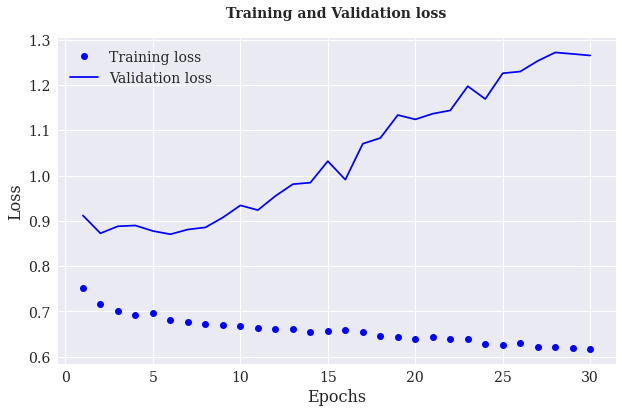

In [26]:
plt.plot(epochs, loss_values,'bo', label='Training loss')
plt.plot(epochs, val_loss_values,'b', label='Validation loss')
plt.title('Training and Validation loss',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

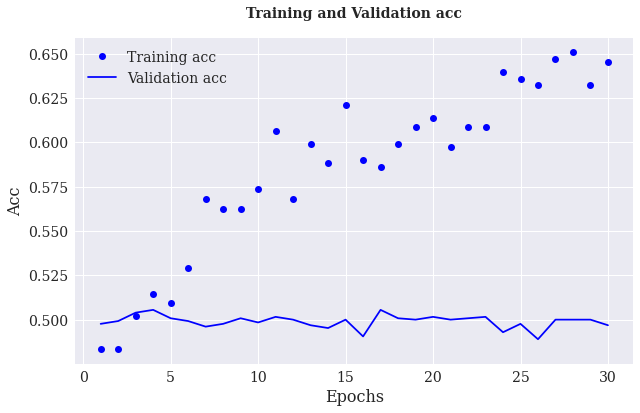

In [27]:
plt.plot(epochs, acc_values,'bo', label='Training acc')
plt.plot(epochs, val_acc_values,'b', label='Validation acc')
plt.title('Training and Validation acc',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [28]:
backtest = backtest[5:].copy()

In [29]:
backtest.shape

(775, 1)

In [30]:
model.predict(X_test).round().shape

(775, 1)

In [31]:
backtest['pred']=model.predict(X_test).round()
backtest['pred']=np.where(backtest['pred']==1,1,-1)  

In [32]:
backtest['strategy'] = backtest['pred'] * backtest['returns']

In [33]:
backtest.tail()

,returns,pred,strategy
Date,,,
2020-07-17,-0.005113,1,-0.005113
2020-07-20,0.042083,1,0.042083
2020-07-21,-0.013560,-1,0.013560
2020-07-22,0.014269,1,0.014269
2020-07-23,-0.044469,-1,0.044469


In [34]:
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 775 entries, 2017-06-26 to 2020-07-23
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   returns   775 non-null    float64
 1   pred      775 non-null    int64  
 2   strategy  775 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.2 KB


In [35]:
backtest.describe()

,returns,pred,strategy
count,775.000000,775.000000,775.000000
mean,0.001349,0.130323,0.001739
std,0.019243,0.992112,0.019212
min,-0.159453,-1.000000,-0.159453
25%,-0.006159,-1.000000,-0.006745
50%,0.001610,1.000000,0.001287
75%,0.010096,1.000000,0.009749
max,0.132929,1.000000,0.132929


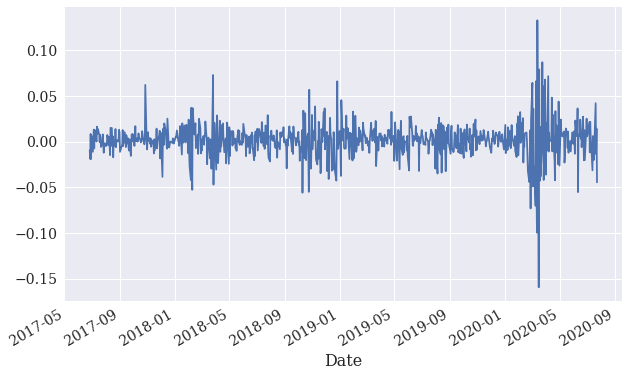

In [36]:
backtest['returns'].plot()

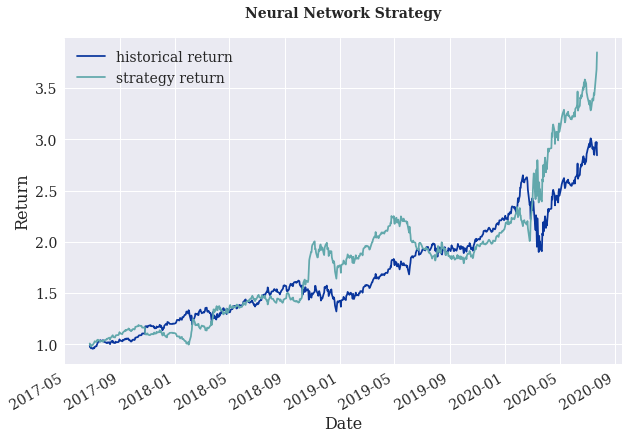

In [37]:
plt.figure()
plt.title('Neural Network Strategy',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(backtest['returns'].cumsum().apply(np.exp), label='historical return', color='#0A369D')
plt.plot(backtest['strategy'].cumsum().apply(np.exp), label='strategy return', color='#62a8ac')
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');
# plt.savefig('classification_strategy.png', facecolor='None')

<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>